#  <center>I’m Something of a Painter Myself: Use GANs to Create Art</center>
## <div style="text-align: right;"> ----5511 Week5 Project </div>

## 1. Introduction
### 1.1. Generative Adversarial Networks (GANs)
Generative Adversarial Networks (GANs) are a class of artificial intelligence algorithms used in unsupervised machine learning, capable of generating new data instances. They consist of two neural networks: a generator, which creates new data samples, and a discriminator, which evaluates the generated samples for authenticity. Through adversarial training, where the generator aims to produce realistic samples to fool the discriminator, GANs can generate high-quality synthetic data, often indistinguishable from real data.

### 1.2. Project Goal
For this project, I will generate images in the style of Monet. This generator will be trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images. My task is to build a GAN that generates 7,000 to 10,000 Monet-style images for the competition.

## 2. Exploratory Data Analysis 
### 2.1. Import the libraries and connect to TPU

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1
2.2.0


### 2.2 Load in the data

In [6]:
# set the path
GCS_PATH = '/kaggle/input/monet-gan-getting-started'

In [7]:
# import the files
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [8]:
IMAGE_SIZE = [256, 256]

# write the function to extract the images
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [9]:
# write the function to load the dataset
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [10]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [11]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's first look at some sample images

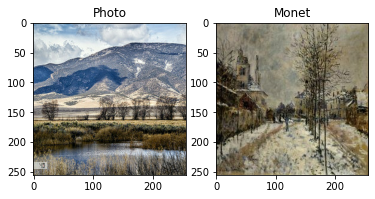

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### 2.3. Data Overview
* All the images are already sized to 256x256. 
* These images are RGB images, set the channel to 3. 
* 300 Monet paintings sized 256x256 in JPEG format
* 7028 photos sized 256x256 in JPEG format

### 2.4. Visualizations


To do some basic EDA, let us first examine several images from each class.

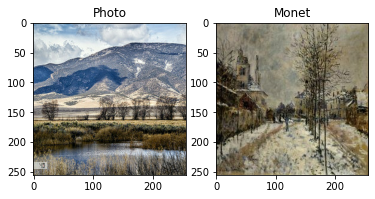

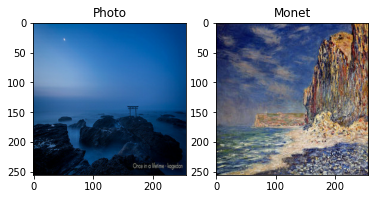

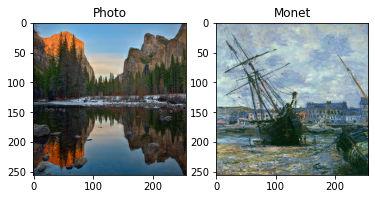

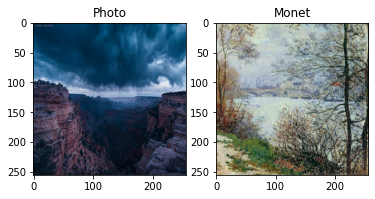

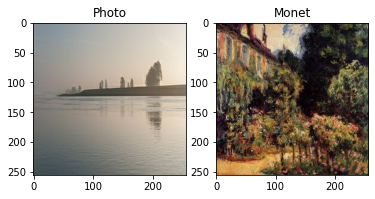

In [62]:
for example_monet, example_photo in zip(monet_ds.take(5), photo_ds.take(5)):
    plt.subplot(122)
    plt.title('Monet')
    plt.imshow(example_monet[0]*0.5+0.5)
    
    plt.subplot(121)
    plt.title('Photo')
    plt.imshow(example_photo[0]*0.5+0.5)
    plt.show()

From these images, we can observe that photos exhibit heightened realism and intricate detail, while Monet's painting appears somewhat "blurred" and imbued with an air of surrealism.

Now, let's conduct a scientific analysis of some images by plotting the distribution of pixel intensities in the sample images for each channel (Red, Green, and Blue) separately to see the underlying causes of the differences.

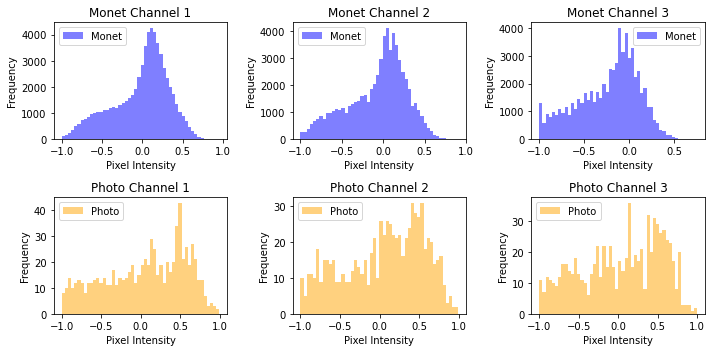

In [63]:
plt.figure(figsize=(10, 5))
for i in range(3):
    # Monet histogram
    plt.subplot(2, 3, i + 1)
    plt.hist(monet_samples[0][:, :, i].flatten(), bins=50, color='blue', alpha=0.5, label='Monet')
    plt.title(f'Monet Channel {i+1}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Photo histogram
    plt.subplot(2, 3, i + 4)
    plt.hist(photo_samples[0][:, :, i].flatten(), bins=50, color='orange', alpha=0.5, label='Photo')
    plt.title(f'Photo Channel {i+1}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

Here is what I found from the histograms:

- **Monet Histograms**:
  - Display bell-shaped, symmetrical curves suggesting even distribution of color intensities.
  - Peaks are centered, indicating a balanced mix of light and dark tones.
  - Slight skew towards darker tones in two channels, possibly indicating Green and Blue channels in Monet-styled images.

- **Photo Histograms**:
  - Show irregular, multi-peaked distributions reflecting a variety of color intensities typical in natural scenes.
  - Each channel has a distinct distribution pattern, implying a non-uniform color representation in photographs.
  - Sharp peaks in certain channels hint at prevalent color intensities, likely due to specific features in the photos.

- **Comparative Insights**:
  - Monet-styled images exhibit uniformity characteristic of his painting style, with a consistent application of colors.
  - Photographs display greater complexity in color distribution, representing the wide range of intensities found in real-life imagery.

- **Artistic vs. Natural**:
  - The differences in histograms highlight the contrast between Monet's artistic color use and the diverse, complex colors in photographs of natural scenes.


## 3. Model Architecture
For the CycleGAN implementation, I will use the UNET architecture due to its proven efficacy in image-to-image translation tasks. The UNET's symmetrical encoder-decoder design facilitates seamless mapping between input and output domains, preserving fine details and spatial relationships.

In constructing our generator, we employ `downsample` and `upsample` operations. Downsampling, executed through strided convolutions, reduces image dimensions, capturing high-level features efficiently. Upsampling, achieved via transposed convolutions or interpolation followed by convolution, restores spatial resolution, ensuring the fidelity of generated outputs.

Furthermore, we employ instance normalization instead of batch normalization within our network. Instance normalization, by normalizing each sample individually, stabilizes training and enhances generalization, mitigating internal covariate shift.

While instance normalization isn't native to TensorFlow, we integrate the TensorFlow Add-ons layer seamlessly into our architecture.

Our approach emphasizes efficiency and accuracy in image translation tasks, leveraging the UNET architecture's strengths alongside careful normalization techniques to achieve optimal results in CycleGAN implementation.

In [64]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [65]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### 3.1. Build the Generator

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [66]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### 3.2. Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [67]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [68]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Because our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

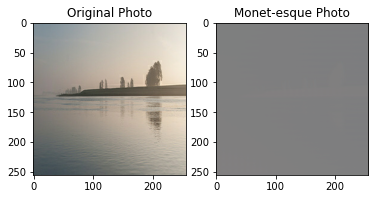

In [69]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### 3.3. Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

In [70]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### 3.4. Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [71]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [72]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [73]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [74]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### 3.5. Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [75]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [76]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [78]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
300/300 [==============================] - 1449s 5s/step - monet_gen_loss: 4.9309 - photo_gen_loss: 5.0592 - monet_disc_loss: 0.6171 - photo_disc_loss: 0.6053
Epoch 2/10
300/300 [==============================] - 1444s 5s/step - monet_gen_loss: 3.7267 - photo_gen_loss: 3.8444 - monet_disc_loss: 0.6535 - photo_disc_loss: 0.5946
Epoch 3/10
300/300 [==============================] - 1448s 5s/step - monet_gen_loss: 3.6413 - photo_gen_loss: 3.7661 - monet_disc_loss: 0.6443 - photo_disc_loss: 0.5954
Epoch 4/10
300/300 [==============================] - 1443s 5s/step - monet_gen_loss: 3.5496 - photo_gen_loss: 3.7592 - monet_disc_loss: 0.6389 - photo_disc_loss: 0.5751
Epoch 5/10
300/300 [==============================] - 1443s 5s/step - monet_gen_loss: 3.4228 - photo_gen_loss: 3.6407 - monet_disc_loss: 0.6308 - photo_disc_loss: 0.5782
Epoch 6/10
300/300 [==============================] - 1442s 5s/step - monet_gen_loss: 3.3024 - photo_gen_loss: 3.5127 - monet_disc_loss: 0.6254 - phot

### 3.6. Visualize the Monet-esque photos

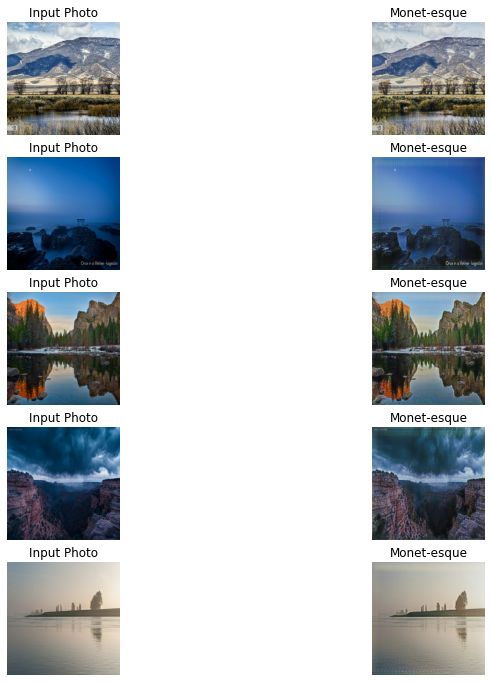

In [79]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## 4. Submission

In [80]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

## 5. Results, Summary, and Conclusion

In summary, the CycleGAN model offers promising possibilities for image translation tasks, displaying satisfactory outcomes with relatively minimal epochs. However, maximizing its potential needs a lot of adjustments and exploration of various strategies. Here's a breakdown:

- **Model Enhancement**: Augmenting the generators and discriminators with additional layers to improve data comprehension.
- **Extended Training**: Increasing the number of epochs to refine model accuracy and convergence.
- **Varied Preprocessing**: Exploring diverse preprocessing techniques to expedite model convergence and enhance performance. 

With these considerations, my model showcased a satisfactory performance, with a MiFID score with 74. Moving forward, I can consider the following steps:

* Add more epochs to refine the model(I only did 10 epochs in the interest of time).
* Preprocess the images differently to compare the difference.
* Spend more time to explore different architectures and on hyperparameter tuning. 